<a href="https://colab.research.google.com/github/Japheth001/RedditSentimentWebsite/blob/main/RedditSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Sentiment Analysis!

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from IPython import display  # control displaying of printed output in loops
from pprint import pprint  # pretty print json and lists
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
!pip install praw
import praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.1 MB/s eta 0:00:00


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Exploring the Reddit API using PRAW

Access the Reddit API. This allows you to easilly acess data from Reddit. To do this go to https://www.reddit.com/prefs/apps/.

In [3]:
reddit = praw.Reddit(client_id='Cvu8zva7-vmcWJZQ3GWLQw',
                     client_secret='ax30Yo8NBEyOmF9jX21owCPiAo1BHA',
                     user_agent='health_narrative_research',
                     username='<your user_name')

In [4]:
# subreddit1 = reddit.subreddits.search_by_name('datascience', exact=True)  returns a list of search results
subreddit_name = 'depression'
subreddit = reddit.subreddit(subreddit_name)
print("Display Name:")
print(subreddit.display_name)
print()
print("Title:")
print(subreddit.title)
print()
print("Description")
print(subreddit.description)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Display Name:
depression

Title:
/r/depression, because nobody should be alone in a dark place

Description
###Community Basics

We offer a [peer-support](https://www.reddit.com/r/depression/wiki/giving_help) space for anyone dealing with a depressive disorder in themselves or someone close to them.

[Please stay on topic](https://www.reddit.com/r/depression/wiki/what_is_depression). Depression is both important and difficult to talk about so focus is essential. Posts here need to be support requests specifically related to depression, and comments need to be supportive of the OP.

If you want to talk about thoughts or risk of suicide, please post at /r/SuicideWatch. If you've lost someone to suicide, /r/SuicideBereavement is the best community to get support.

It might seem that we have a lot of rules, but we've found they're all necessary to maintain as much emotional and physical safety as possible. Most people are surprised by at least some of our policies so please [read all of th

In [5]:
posts = set()  # use a set to clear any duplicates
for post in subreddit.new(limit=None):
  posts.add(post)
  display.clear_output()  # only one output that changes
  print(len(posts))
posts = list(posts)  # easier to work with lists

988


In [23]:
post = posts[7]
print(post.title)
print(post.author)
print(post.score)
print(post.id)
print(post.url)

Living with my toxic parents
Fluid_Valuable5337
3
1nkvjmj
https://www.reddit.com/r/depression/comments/1nkvjmj/living_with_my_toxic_parents/


Using the Reddit API, we can also explore comments. Maybe we can make a model that looks at comments as well as titles?

In [24]:
# this creates a list of comments from the post we already defined
comments = list(post.comments)
# pprint(vars(comments[7]))  # gives us variables for comment
print('Post Title:', post.title)
print()
print('Comment: ', comments[7].body)
print()
print('Comment Author: ', comments[7].author)
print('Score: ', comments[7].score)  # would be nice to have model weigh this too

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Post Title: Living with my toxic parents



IndexError: list index out of range

## Basic Sentiment Analysis Using Pretrained Models


For now, we will explore various pretrained models that detect negative and positive sentiment. Alternativley, we could train our own model using a dataset and sklearn. However, these pretrained models actually perform pretty well.

The main model that we are using is vader from nltk. This model has been pretrained specifically for social media text. A detailed paper describing the model can be found at https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text.

Code for other models is commented out because we are not using them. You can uncomment to explore them though.

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
# from textblob import TextBlob
# !pip install flair
# import flair
# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [26]:
sentence = "This food was great but the service was only okay"
print("NLTK VADER")
print(sia.polarity_scores(sentence))
# print()
# print("Text Blob:")
# print(TextBlob(sentence).sentiment)
# print()
# print("Flair:")
# s = flair.data.Sentence(sentence)
# flair_sentiment.predict(s)
# total_sentiment = s.labels
# print(total_sentiment)

NLTK VADER
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5994}


In [27]:
results = list()

for post in posts:
    pol_score = sia.polarity_scores(post.title)
    pol_score['headline'] = post.title
    results.append(pol_score)

pprint(results[:3], width=100)  # pretty print

[{'compound': -0.553,
  'headline': 'I really want to die right now',
  'neg': 0.427,
  'neu': 0.41,
  'pos': 0.163},
 {'compound': -0.2732,
  'headline': 'Masturbation Causes Drop In Mood',
  'neg': 0.344,
  'neu': 0.656,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'Has therapy or meds helped you guys?',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


Now we will store the data as a pandas dataframe. We will create a new column, 'label', that will store if the headline is positive (1), neutral (0), or negative (-1). We have used 0.2 and -0.2 as our thresholds but this can be altered (giving us different results).

In [28]:
df = pd.DataFrame.from_records(results)
sorted_df = df.sort_values(by='compound')
df['label'] = 0  # creates label column
df.loc[df['compound'] > 0.2, 'label'] = 1  # if compound score is greater than 0.2 we label it as positive
df.loc[df['compound'] < -0.2, 'label'] = -1  # if compound score is less than -0.2 we label it as positive
df.sample(n=10,axis='rows')  # prints 10 random items from the dataframe

,neg,neu,pos,compound,headline,label
186,0.529,0.471,0.000,-0.6705,My gf is always suicidal,-1
736,0.560,0.119,0.321,-0.2500,No support - unbearably lonely,-1
842,0.286,0.390,0.325,0.0772,I feel like im missing something,0
237,0.404,0.596,0.000,-0.5256,I am so ashamed of my CV,-1
952,0.000,1.000,0.000,0.0000,I can’t,0
15,0.000,1.000,0.000,0.0000,PHQ9,0
769,0.688,0.312,0.000,-0.2960,No choice,-1
308,0.756,0.244,0.000,-0.7351,Avoid self destructive behaviour,-1
362,0.234,0.766,0.000,-0.0572,I dont want to live anymore,0
246,0.382,0.618,0.000,-0.7777,What a waste of life it has been....just putti...,-1


Now that we have our results, we can save them in a csv file!

In [29]:
df.to_csv('{}_sentiment'.format(subreddit_name))

The below code clearly shows the analysis of a subreddit.

In [30]:
percentages = df.label.value_counts(normalize=True) * 100
for key in percentages.keys():
    if key == -1:
        percentages['Negative'] = percentages[key]
        del percentages[key]
    if key == 0:
        percentages['Neutral'] = percentages[key]
        del percentages[key]
    if key == 1:
        percentages['Positive'] = percentages[key]
        del percentages[key]
print(percentages)

label
Negative    47.874494
Neutral     35.931174
Positive    16.194332
Name: proportion, dtype: float64


## Exploring Our Results

We can explore the most positive and negative headlines using the below code.

In [31]:
sorted_df = df.sort_values(by='compound')
print('Five Most Positive Titles:')
for headline in list(sorted_df.tail(5)['headline']):
  print(headline)
print()
print('Five Most Negative Titles:')
for headline in list(sorted_df.head(5)['headline']):
  print(headline)


Five Most Positive Titles:
I wish dying was easy and painless
hi everyone. please if anyone can read this and help me it would be great. this is my last cry for help. im sorry for making it long.
Vicious cycle of ambition but no view of success and happiness
Sometimes I feel like giving up is better than challenging my parents on my career
Resources to help my partner understand how to best support me when I need to talk about my feelings?

Five Most Negative Titles:
fuck fuck fuck fuck all of you I hate everyone so much
I want to commit suicide but it will destroy my dad’s cancer treatment.
i hate that i can’t kill myself (because it will destroy my Mother and i just can’t do that to her)
I suffer from Severe Depression and get constantly mocked by others
I’m just so sick of fighting the bad feelings.


This code will print the first five negative results and the first five positive results. These do not take into account how positive or negative that they are.

In [32]:
positive_results = df[df['label'] == 1]
negative_results = df[df['label'] == -1]
print("Postitive Results:")
pprint(list(positive_results['headline'])[:5])
print()
print("Negative Results:")
pprint(list(negative_results['headline'])[:5])

Postitive Results:
['Resources to help my partner understand how to best support me when I need '
 'to talk about my feelings?',
 "I was 'invited' to a party, but left on read when I asked what time it "
 "started, so I didn't go.",
 'Help?',
 'After 4 years off my meds and everything seeming to get better I find myself '
 'back in the hole.',
 'The hardest part of saying "I love you"']

Negative Results:
['I really want to die right now',
 'Masturbation Causes Drop In Mood',
 'How to deal with suicide ideation?',
 'I want to commit suicide',
 'Sad Sunday’s']


Now we can determine the overall sentiment of a subreddit by creating percentages of positive, neutral, and negative headlines.

In [33]:
percentages = df.label.value_counts(normalize=True) * 100
print("Count:")
print(df.label.value_counts())
print()
print("Percentages:")
print(percentages)

Count:
label
-1    473
 0    355
 1    160
Name: count, dtype: int64

Percentages:
label
-1    47.874494
 0    35.931174
 1    16.194332
Name: proportion, dtype: float64


The below code lets us visualize the above results.

[]

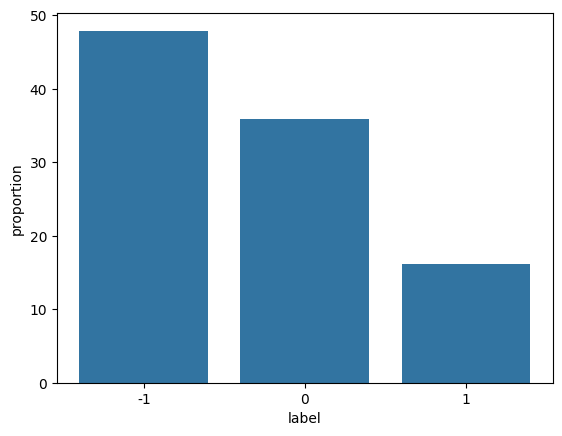

In [34]:
sns.barplot(x=percentages.index, y=percentages)
plt.xlabel = ['Negative', 'Nuetral', 'Positive']
plt.plot()

## Future Model Improvement

We classified a subreddit's sentiment soley based on the titles of its top posts. Maybe we can look at more data such as comments and upvotes. Using this same idea, we may also be able to make a more practical model, such as a fake news or hate speech detector. This would involve using different models and potentially needing training data.

## Now What?

In this notebook, we have explored the Reddit API, and different sentiment analysis models. We have also been able to visualize our results. Using these ideas and the code as a foundation, we can turn this into something more accesible. For example, we can make a website where a user types in a subreddit and get a sentiment analysis back. We can make a cli to
 analyze subreddits in the command line.